In [5]:
import pyterrier as pt
import pandas as pd
from pyterrier.measures import RR, nDCG, MAP

In [6]:
dataset = pt.get_dataset("irds:beir/fiqa")

In [9]:
# Install the nlpaug package
# %pip install nlpaug

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [210]:
text_ocr = 'The quick brown fox jumps over the lazy dog .'
text_key = 'The quick brown fox jumps over the lazy dog .'

aug = nac.OcrAug(aug_char_p=0.3, aug_word_p=0.3)
augmented_texts_ocr = aug.augment(text_ocr)

aug_key = nac.KeyboardAug(aug_char_p=0.3, aug_word_p=0.3)
augmented_texts_key = aug_key.augment(text_key)

print("Original:")
print(text)
print("Augmented Texts OCR:")
print(augmented_texts_ocr)
print("Augmented Texts Keyboard:")
print(augmented_texts_key)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Texts OCR:
['The 9oicr 6k0wn fux jumps uvek the 1a2y d09.']
Augmented Texts Keyboard:
['The quick bdo#n fox y7mps over the ,xzy dog.']


In [212]:
# Add noise to the documents OCR
noisy_dataset = []
bool = False

aug = nac.OcrAug(aug_char_p=0.3, aug_word_p=0.3, aug_word_min=1, aug_word_max=500000)

for doc in dataset.get_corpus_iter():
    noisy_text = aug.augment(doc['text'])
    noisy_doc = {'docno': doc['docno'], 'text': noisy_text}
    noisy_dataset.append(noisy_doc)

    if not bool:
        print(doc['text'])
        print("Noisy:")
        print(noisy_text)
        bool = True

beir/fiqa documents:   0%|          | 88/57638 [00:00<02:02, 471.41it/s]

I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.
Noisy:
["I ' m not saying 1 don ' t like the idea of on - the - j06 training too, but you can ' t expect the cumpany tu d0 that. Training workers is not their job - they ' re building 80ftwake. Perhaps educational 8y8tem8 in the O. S. (or their 8todent8) should worry a 1itt1e about getting makretab1e skills in exchange for their massive investment in edocati0n, rather than getting out with thoo8and8 in 8todent debt and then cump1ainin9 that they aren ' t 9oa1ified to do anything."]


beir/fiqa documents: 100%|██████████| 57638/57638 [01:11<00:00, 802.11it/s]


In [24]:
# Indexing noisy documents - takes too long
# from pathlib import Path

# indexer = pt.IterDictIndexer(
#     str(Path.cwd()),  # this will be ignored
#     type=pt.index.IndexingType.MEMORY,
# )
# index_ref = indexer.index(noisy_dataset, fields=["text"])

In [25]:
# To test the noisy documents
# bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
# testset = pt.get_dataset("irds:beir/fiqa/test")
# pt.Experiment(
#     [bm25],
#     testset.get_topics(),
#     testset.get_qrels(),
#     eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
# )

In [216]:
# Indexing documents
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
)
index_ref = indexer.index(dataset.get_corpus_iter())

beir/fiqa documents: 100%|██████████| 57638/57638 [00:27<00:00, 2087.58it/s]


In [217]:
# Add noise to the queries
# Load the test dataset
testset = pt.get_dataset("irds:beir/fiqa/test")

# Retrieve test queries
test_queries = testset.get_topics()

# Add noise by deleting characters 10% of the time
aug = nac.RandomCharAug(action="delete", aug_char_p=0.1, spec_char="")

# Apply noise to queries
noisy_queries_list = []
for _, row in test_queries.iterrows():
    noisy_query = aug.augment(row['query'])

    if isinstance(noisy_query, list):
        noisy_query = " ".join(noisy_query)

    noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

noisy_queries_df = pd.DataFrame(noisy_queries_list)
noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

print("Original Query:", test_queries.iloc[0]['query'])
print("Noisy Query:", noisy_queries_df.iloc[0]['query'])

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

# Run the experiment
pt.Experiment(
    [bm25],
    noisy_queries_df,
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)

[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


Original Query: where should i park my rainy day emergency fund
Noisy Query: were should i ark my raiy day emergency fund
23:52:04.937 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.142997,0.120655,0.097932


In [220]:
testset = pt.get_dataset("irds:beir/fiqa/test")
test_queries = testset.get_topics()

# Define noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
results = []

for noise_level in noise_levels:

    aug = nac.OcrAug(aug_char_p=0.25, aug_word_p=noise_level, aug_word_min=0, aug_word_max=500000)

    # Apply noise to queries
    noisy_queries_list = []
    for _, row in test_queries.iterrows():
        noisy_query = aug.augment(row['query'])
        if isinstance(noisy_query, list):
            noisy_query = " ".join(noisy_query)
        noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

    noisy_queries_df = pd.DataFrame(noisy_queries_list)
    noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

    print("Original query:", test_queries.iloc[0]['query'])
    print("Noisy query:", noisy_queries_df.iloc[0]['query'])

    # Run retrieval experiment
    eval_result = pt.Experiment(
        [bm25],
        noisy_queries_df,
        testset.get_qrels(),
        eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
    )

    # Store results
    eval_result["noise_level"] = noise_level
    results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
print(final_results)

Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
23:57:57.826 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: wheke should i park my rainy day emek9ency fund
Original query: where should i park my rainy day emergency fund
Noisy query: wheke should i park my rainy day emek9ency fund
Original query: where should i park my rainy day emergency fund
Noisy query: wheke should i pakr my kainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: where should i 

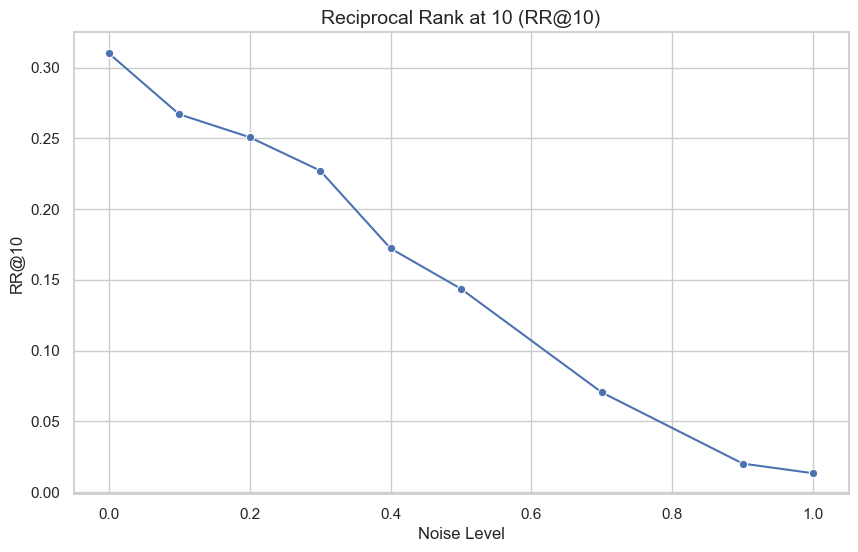

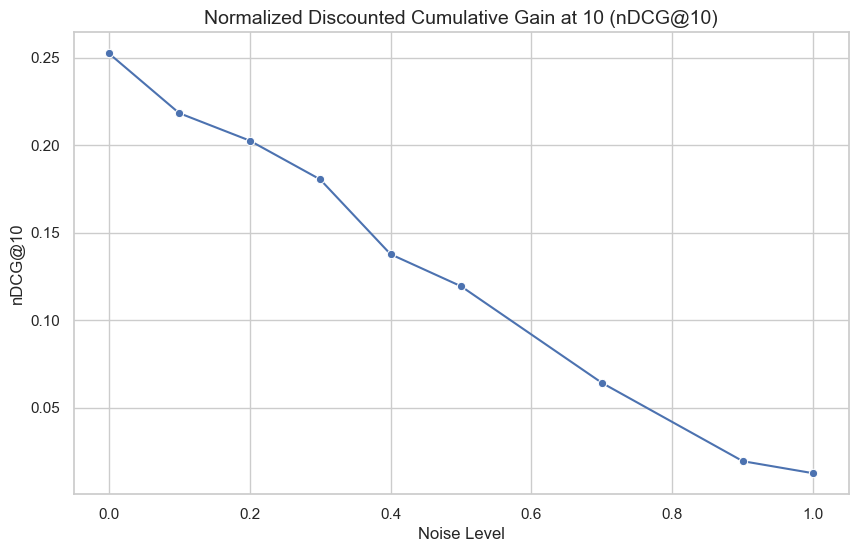

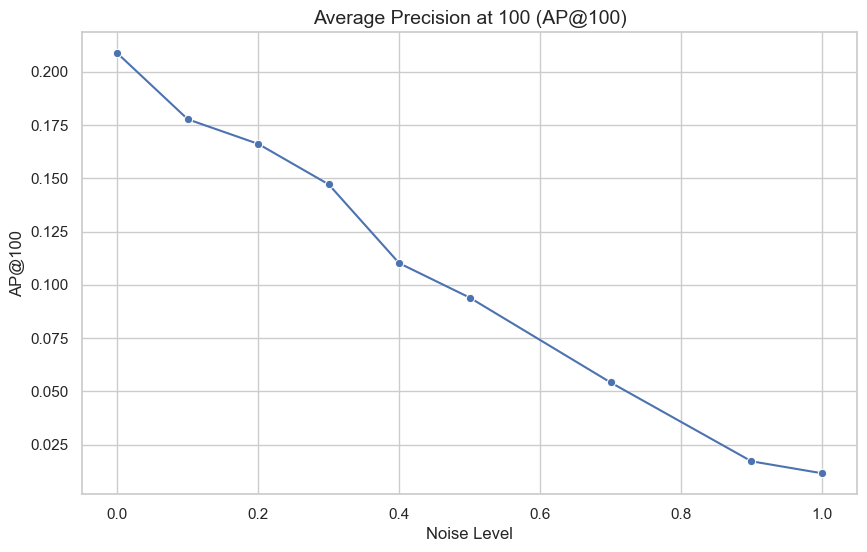

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_metric(metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=final_results,
        x="noise_level",
        y=metric,
        marker="o",
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.show()

plot_metric("RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric("AP@100", "Average Precision at 100 (AP@100)")

In [228]:
testset_2 = pt.get_dataset("irds:beir/fiqa/test")
test_queries_2 = testset_2.get_topics()

# Define noise levels
noise_levels_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

bm25_2 = pt.terrier.Retriever(index_ref, wmodel="BM25")
results_2 = []

for noise_level in noise_levels_2:

    aug_2 = nac.KeyboardAug(aug_char_p=0.25, aug_word_p=noise_level, include_special_char=False, aug_word_min=0, aug_word_max=500000)

    # Apply noise to queries
    noisy_queries_list_2 = []
    for _, row in test_queries_2.iterrows():
        noisy_query_2 = aug_2.augment(row['query'])
        if isinstance(noisy_query_2, list):
            noisy_query_2 = " ".join(noisy_query_2)
        noisy_queries_list_2.append({'qid': row['qid'], 'query': noisy_query_2})

    noisy_queries_df_2 = pd.DataFrame(noisy_queries_list_2)
    noisy_queries_df_2["qid"] = noisy_queries_df_2["qid"].astype(str)

    print("Original query:", test_queries_2.iloc[0]['query'])
    print("Noisy query:", noisy_queries_df_2.iloc[0]['query'])

    # Run retrieval experiment
    eval_result_2 = pt.Experiment(
        [bm25_2],
        noisy_queries_df_2,
        testset_2.get_qrels(),
        eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
    )

    # Store results
    eval_result_2["noise_level"] = noise_level
    results_2.append(eval_result_2)

# Combine results
final_results_2 = pd.concat(results_2, ignore_index=True)
print(final_results_2)

Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
00:16:15.057 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Original query: where should i park my rainy day emergency fund
Noisy query: where shohPd i park my rainy day emergency fund
Original query: where should i park my rainy day emergency fund
Noisy query: wMeGe should i park my rainy day ejergenXH fund
Original query: where should i park my rainy day emergency fund
Noisy query: whfDe ZhoIld i park my rainy day fmDryency fund
Original query: where should i park my rainy day emergency fund
Noisy query: where shI6ld i parL my 5Qiny day 2m3rYency fund
Original query: where should i park my rainy day emergency fund
Noisy query: where sh9uid i 

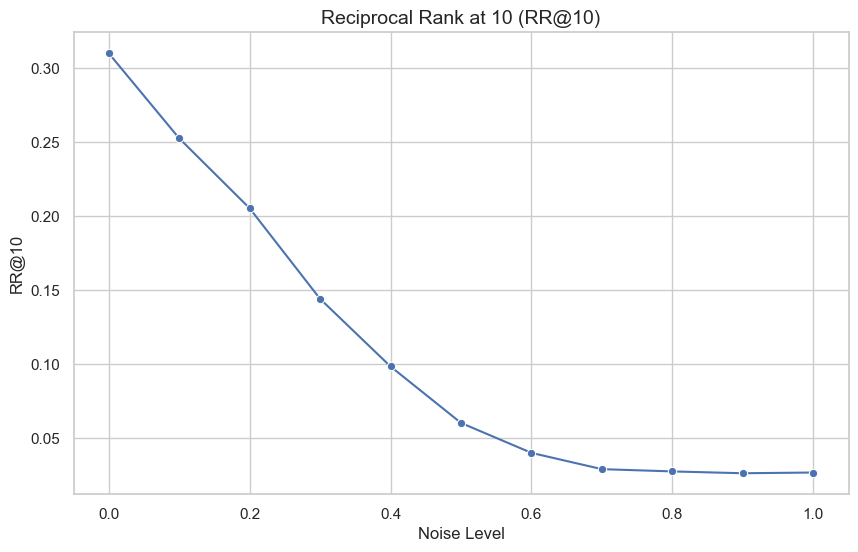

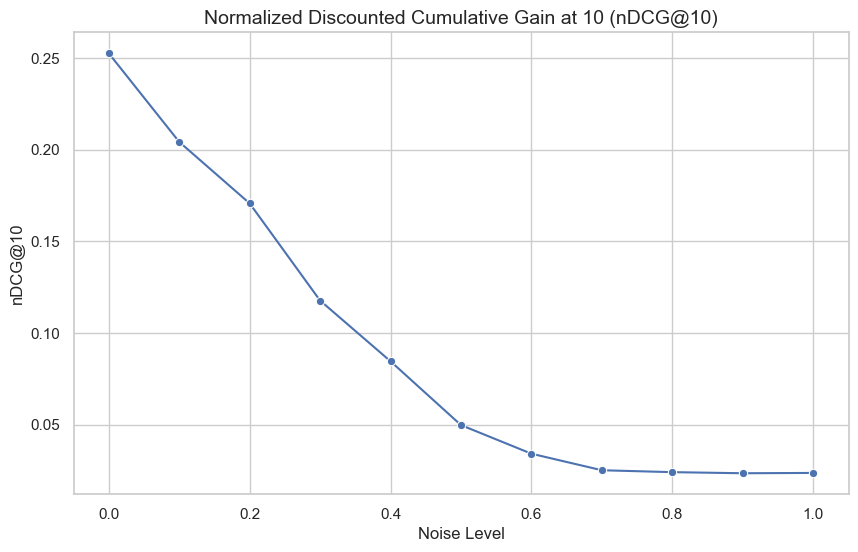

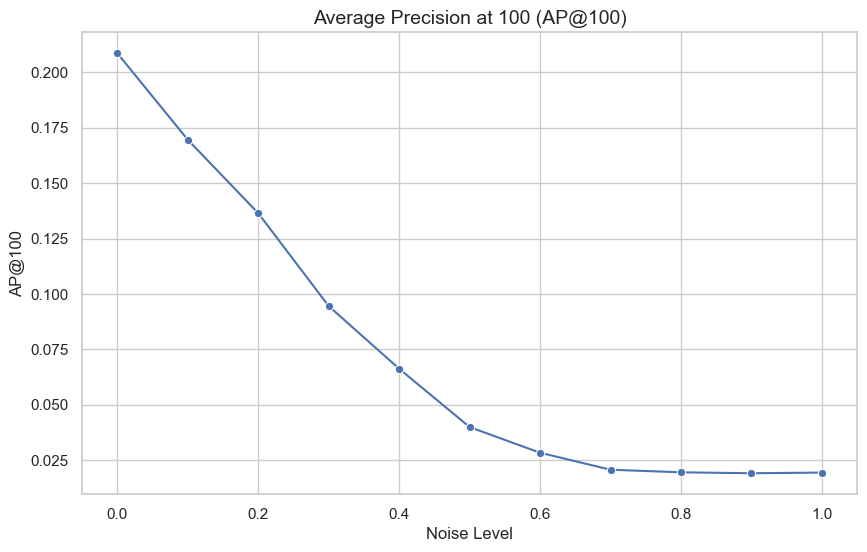

In [229]:
sns.set(style="whitegrid")

def plot_metric_2(metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=final_results_2,
        x="noise_level",
        y=metric,
        marker="o",
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.show()

plot_metric_2("RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric_2("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric_2("AP@100", "Average Precision at 100 (AP@100)")